# MCMC-Based Machine Unlearning (MCU) on Real Phishing Dataset

> This notebook mirrors the experiment in the synthetic MCU notebook, but uses a **real phishing website dataset** instead of a generated one.

---

We will:
- Load and preprocess a real phishing dataset (features + binary label).
- Train a Bayesian logistic regression model with NumPyro using NUTS MCMC.
- Define an erase set $D_e$ and retain set $D_r$.
- Apply MCU (importance sampling) to approximate retraining on $D_r$ **without** full retraining.
- Compare against an actual retrained model on $D_r$ using accuracy and Wasserstein distance.

## Section 1 — Setup & Imports

We install NumPyro (for Bayesian inference with JAX) and import all required libraries.

This notebook is intended to run on a Colab runtime (CPU/GPU) connected from VS Code; each new runtime will require re-running the installation cell.

In [11]:
# Install NumPyro in the Colab runtime (run once per session)
!pip install -q numpyro


In [12]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Reproducibility
np.random.seed(42)

print(f"JAX version  : {jax.__version__}")
print(f"NumPyro ver  : {numpyro.__version__}")
print(f"JAX backend  : {jax.default_backend()}")

JAX version  : 0.7.2
NumPyro ver  : 0.20.0
JAX backend  : cpu


## Section 2 — Load and Preprocess Real Phishing Dataset

This replaces the synthetic `make_classification` dataset.

Assumptions (you can tweak these):
- You have a phishing dataset stored as a CSV file (e.g., UCI Phishing Websites converted to CSV).
- The label column is named `Result` with values `1` (phishing) and `-1` (legitimate).
- All other columns are feature columns (integer flags like −1/0/1).

If your file or column names differ, adjust `DATA_PATH` and `LABEL_COLUMN` below.

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!ls -R "/content/drive/MyDrive"

In [7]:
# Download ARFF from UCI into Colab
# I have uploaded the dataset to my Google drive and mount it here from within vscode notebook. You can do the same or download it directly from UCI and upload to Colab.
from scipy.io import arff
import pandas as pd

ARFF_PATH = "/content/drive/MyDrive/phishing_websites.arff"  # adjust path/folder
CSV_PATH  = "/content/phishing_websites.csv"  # stays in runtime

# Convert ARFF → DataFrame → CSV
data, meta = arff.loadarff(ARFF_PATH)
df = pd.DataFrame(data)
# Decode byte strings coming from ARFF
for col in df.columns:
    if df[col].dtype == object:
        df[col] = df[col].apply(
            lambda x: x.decode("utf-8") if isinstance(x, bytes) else x
        )

# Convert anything that looks numeric into numbers
df = df.apply(pd.to_numeric, errors="ignore")
df.to_csv(CSV_PATH, index=False)

print("Saved to ", CSV_PATH)
print(df.head())

/tmp/ipython-input-788124536.py:20: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors="ignore")


Saved to  /content/phishing_websites.csv
   having_IP_Address  URL_Length  Shortining_Service  having_At_Symbol  \
0                 -1           1                   1                 1   
1                  1           1                   1                 1   
2                  1           0                   1                 1   
3                  1           0                   1                 1   
4                  1           0                  -1                 1   

   double_slash_redirecting  Prefix_Suffix  having_Sub_Domain  SSLfinal_State  \
0                        -1             -1                 -1              -1   
1                         1             -1                  0               1   
2                         1             -1                 -1              -1   
3                         1             -1                 -1              -1   
4                         1             -1                  1               1   

   Domain_registeration_len

Training samples : 2400
Test samples     : 600
Features         : 30
Class balance    : train [1031 1369], test [258 342]


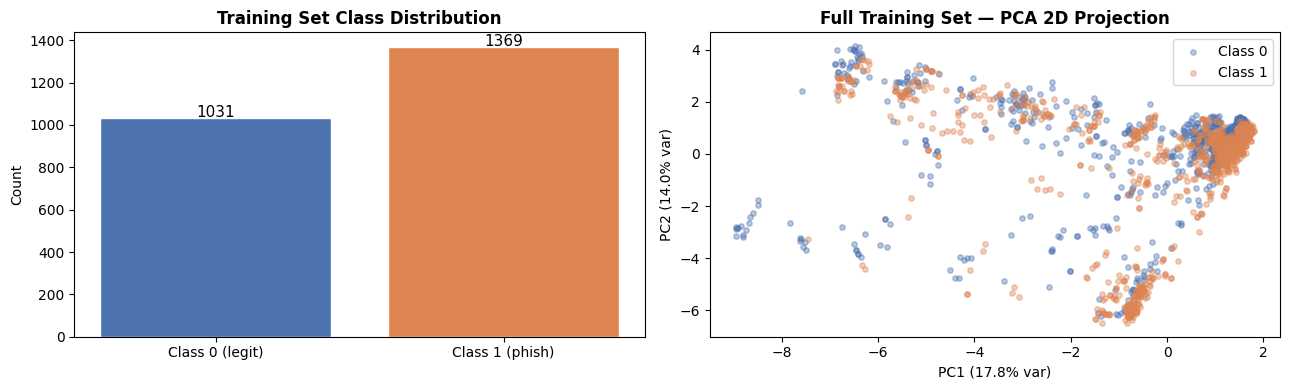

In [13]:
# ---- Configure your dataset path / label column here ----
DATA_PATH = "/content/phishing_websites.csv"  # Update to your actual CSV path
LABEL_COLUMN = "Result"                      # Adjust if your label column is named differently
TEST_SIZE = 0.2
RANDOM_STATE = 42
MAX_TRAIN_SAMPLES = 3000   # Set to None to use all data (slower MCMC)

def load_phishing_dataset(path=DATA_PATH, label_column=LABEL_COLUMN,
                           test_size=TEST_SIZE, random_state=RANDOM_STATE,
                           max_train_samples=MAX_TRAIN_SAMPLES):
    """
    Load a real phishing dataset from CSV and return train/test splits.

    - Expects a binary label column (e.g. 1 = phishing, -1 = legitimate).
    - All other columns are treated as numeric features.
    - Optionally subsamples the dataset to keep MCMC feasible.
    """
    df = pd.read_csv(path)
    if label_column not in df.columns:
        raise ValueError(f"Label column '{label_column}' not found in CSV. Available: {list(df.columns)}")

    y_raw = df[label_column].values
    # Map labels to {0,1}; assume '1' is phishing, anything else is non-phishing
    y = (y_raw == 1).astype(int)
    X = df.drop(columns=[label_column]).values.astype(float)

    # Optional subsampling (for MCMC runtime)
    if max_train_samples is not None and len(X) > max_train_samples:
        X, y = shuffle(X, y, random_state=random_state)
        X = X[:max_train_samples]
        y = y[:max_train_samples]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Scale features to zero mean / unit variance (helps MCMC)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return (X_train, y_train), (X_test, y_test)

# Load data
(X_train, y_train), (X_test, y_test) = load_phishing_dataset()
D_test = (X_test, y_test)

print(f"Training samples : {X_train.shape[0]}")
print(f"Test samples     : {X_test.shape[0]}")
print(f"Features         : {X_train.shape[1]}")
print(f"Class balance    : train {np.bincount(y_train)}, test {np.bincount(y_test)}")

# --- Visualization: Class distribution + PCA overview ---
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Class bar chart
axes[0].bar(["Class 0 (legit)", "Class 1 (phish)"], np.bincount(y_train),
            color=["#4C72B0", "#DD8452"], edgecolor="white")
axes[0].set_title("Training Set Class Distribution", fontweight="bold")
axes[0].set_ylabel("Count")
for i, v in enumerate(np.bincount(y_train)):
    axes[0].text(i, v + 5, str(v), ha="center", fontsize=11)

# PCA 2D scatter of all training data
pca_vis = PCA(n_components=2)
X_2d_vis = pca_vis.fit_transform(X_train)
var_vis = pca_vis.explained_variance_ratio_
for cls, color, label in [(0, "#4C72B0", "Class 0"), (1, "#DD8452", "Class 1")]:
    mask = y_train == cls
    axes[1].scatter(X_2d_vis[mask, 0], X_2d_vis[mask, 1],
                    c=color, alpha=0.4, s=15, label=label)
axes[1].set_title("Full Training Set — PCA 2D Projection", fontweight="bold")
axes[1].set_xlabel(f"PC1 ({var_vis[0]*100:.1f}% var)")
axes[1].set_ylabel(f"PC2 ({var_vis[1]*100:.1f}% var)")
axes[1].legend()
plt.tight_layout()
plt.show()

## Section 3 — Erase Set Configuration on Real Phishing Data

We now split the **training set** into:

- Retain set $D_r$ — data the model should keep using
- Erase set $D_e$ — data to forget

We reuse the two deletion modes from the MCU notebook:
- `random`: remove 5 random training points (small, scattered erase set)
- `cluster`: remove all points whose first feature is above its 90th percentile (larger, structured erase set).

Mode          : RANDOM
Retain set D_r: 2395 samples
Erase  set D_e: 5 samples  (0.2% of training data)


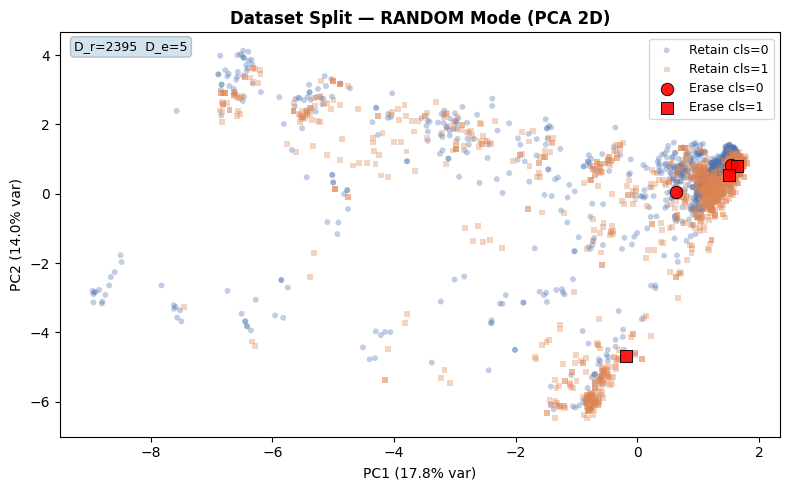

In [39]:
def split_erase_data(X_train, y_train, mode="random", seed=42):
    np.random.seed(seed)
    n_train = len(X_train)
    if mode == "random":
        erase_indices = np.random.choice(n_train, 5, replace=False)
    elif mode == "cluster":
        threshold = np.percentile(X_train[:, 0], 90)
        erase_indices = np.where(X_train[:, 0] > threshold)[0]
    else:
        raise ValueError("Unknown mode.")
    erase_mask = np.zeros(n_train, dtype=bool)
    erase_mask[erase_indices] = True
    D_e = (X_train[erase_mask],  y_train[erase_mask])
    D_r = (X_train[~erase_mask], y_train[~erase_mask])
    return D_e, D_r

# ============================================================
#  TOGGLE HERE:  "random"  or  "cluster"
active_mode = "random"
# ============================================================

D_e, D_r = split_erase_data(X_train, y_train, mode=active_mode)
X_r, y_r = D_r
X_e, y_e = D_e

print(f"Mode          : {active_mode.upper()}")
print(f"Retain set D_r: {len(X_r)} samples")
print(f"Erase  set D_e: {len(X_e)} samples  ({len(X_e)/len(X_train)*100:.1f}% of training data)")

# --- PCA scatter: Retain vs Erase ---
fig, ax = plt.subplots(figsize=(8, 5))
X_all_combined = np.vstack([X_r, X_e])
y_all_combined = np.concatenate([y_r, y_e])
labels_combined = np.array(["Retain"] * len(X_r) + ["Erase"] * len(X_e))

pca_split = PCA(n_components=2)
X_2d_split = pca_split.fit_transform(X_all_combined)
var_split = pca_split.explained_variance_ratio_

style_map = {(0, "Retain"): ("o", "#4C72B0", 0.35, 18),
             (1, "Retain"): ("s", "#DD8452", 0.35, 18),
             (0, "Erase"):  ("o", "red",     0.90, 80),
             (1, "Erase"):  ("s", "red",     0.90, 80)}

for (cls, grp), (mrk, col, alp, sz) in style_map.items():
    mask = (y_all_combined == cls) & (labels_combined == grp)
    if mask.any():
        ax.scatter(X_2d_split[mask, 0], X_2d_split[mask, 1],
                   marker=mrk, c=col, alpha=alp, s=sz,
                   edgecolors="black" if grp == "Erase" else "none",
                   linewidths=0.7,
                   label=f"{grp} cls={cls}")

ax.set_title(f"Dataset Split — {active_mode.upper()} Mode (PCA 2D)", fontweight="bold")
ax.set_xlabel(f"PC1 ({var_split[0]*100:.1f}% var)")
ax.set_ylabel(f"PC2 ({var_split[1]*100:.1f}% var)")
ax.legend(fontsize=9)
ax.text(0.02, 0.98, f"D_r={len(X_r)}  D_e={len(X_e)}",
        transform=ax.transAxes, va="top", fontsize=9,
        bbox=dict(boxstyle="round", alpha=0.2))
plt.tight_layout()
plt.show()

## Section 4 — Bayesian Logistic Regression Model (Same as MCU)

We reuse the same Bayesian logistic regression model and NUTS MCMC setup from the synthetic notebook. The only difference is that `X` and `y` now come from the real phishing dataset.

In [29]:
def bayesian_logistic_regression(X, y=None):
    """NumPyro Bayesian Logistic Regression model for phishing features."""
    n_samples, n_features = X.shape
    w = numpyro.sample("w", dist.Normal(jnp.zeros(n_features), jnp.ones(n_features)))
    b = numpyro.sample("b", dist.Normal(0.0, 1.0))
    logits = jnp.matmul(X, w) + b
    with numpyro.plate("data", n_samples):
        numpyro.sample("obs", dist.Bernoulli(logits=logits), obs=y)

def train_mcmc(X, y, num_warmup=500, num_samples=1000, rng_key=random.PRNGKey(0)):
    """Runs NUTS MCMC and returns posterior samples."""
    kernel = NUTS(bayesian_logistic_regression)
    mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, progress_bar=True)
    mcmc.run(rng_key, X=jnp.array(X, dtype=jnp.float32),
                      y=jnp.array(y, dtype=jnp.float32))
    return mcmc.get_samples()

print("Model defined. Ready for MCMC training on phishing data.")

Model defined. Ready for MCMC training on phishing data.


## Section 5 — Base Model Training on Full Phishing Dataset $D$

Train the Bayesian logistic regression model on the full training set $D = D_r \cup D_e$ (i.e., all phishing samples before unlearning).

Training Base Model on full phishing dataset D = D_r ∪ D_e ...


sample: 100%|██████████| 2000/2000 [00:10<00:00, 187.76it/s, 31 steps of size 1.63e-01. acc. prob=0.94]



Posterior sample shapes:
  w : (1500, 30)   (num_samples × n_features)
  b : (1500,)   (num_samples,)


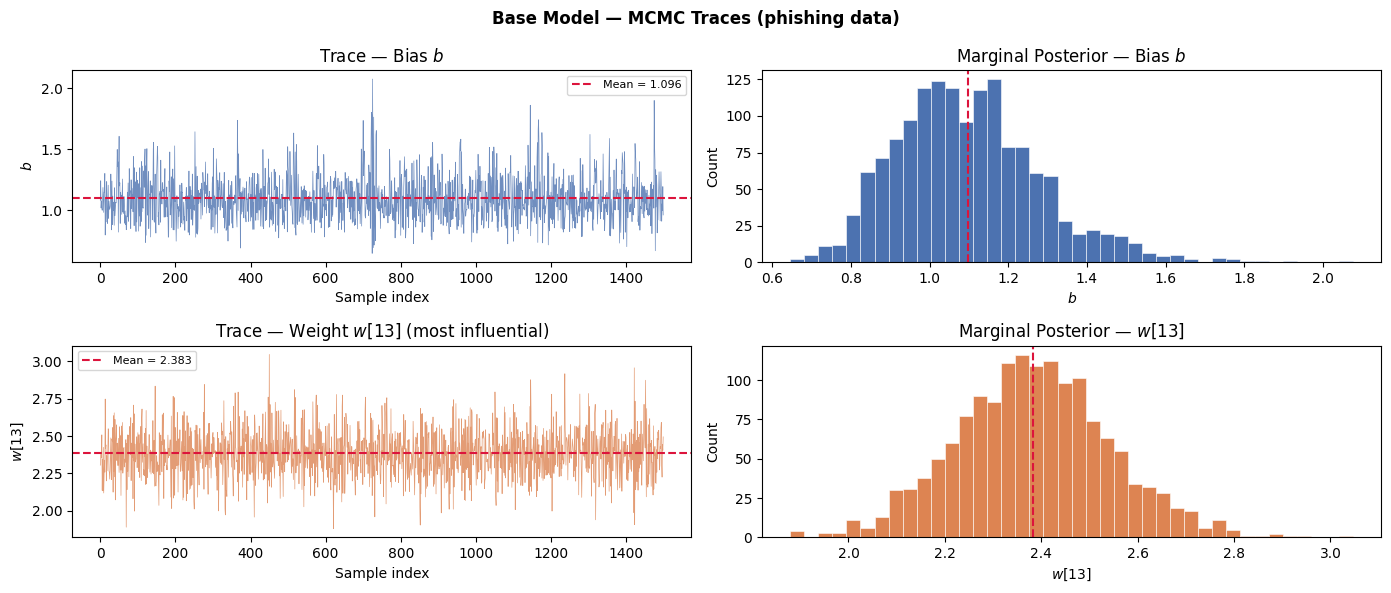

In [18]:
print("Training Base Model on full phishing dataset D = D_r ∪ D_e ...")
X_full = np.vstack((X_r, X_e))
y_full = np.concatenate((y_r, y_e))

base_samples = train_mcmc(X_full, y_full, num_warmup=500, num_samples=1500,
                           rng_key=random.PRNGKey(1))

print(f"\nPosterior sample shapes:")
print(f"  w : {base_samples['w'].shape}   (num_samples × n_features)")
print(f"  b : {base_samples['b'].shape}   (num_samples,)")

# --- MCMC Trace plots (bias b and one influential weight) ---
fig, axes = plt.subplots(2, 2, figsize=(14, 6))
fig.suptitle("Base Model — MCMC Traces (phishing data)", fontweight="bold")

b_base = np.array(base_samples["b"])
w_base = np.array(base_samples["w"])

# Top row: bias b trace + histogram
axes[0, 0].plot(b_base, color="#4C72B0", linewidth=0.5, alpha=0.8)
axes[0, 0].axhline(b_base.mean(), color="crimson", linestyle="--", linewidth=1.5,
                   label=f"Mean = {b_base.mean():.3f}")
axes[0, 0].set_title("Trace — Bias $b$")
axes[0, 0].set_xlabel("Sample index")
axes[0, 0].set_ylabel("$b$")
axes[0, 0].legend(fontsize=8)

axes[0, 1].hist(b_base, bins=40, color="#4C72B0", edgecolor="white", linewidth=0.4)
axes[0, 1].axvline(b_base.mean(), color="crimson", linestyle="--", linewidth=1.5)
axes[0, 1].set_title("Marginal Posterior — Bias $b$")
axes[0, 1].set_xlabel("$b$")
axes[0, 1].set_ylabel("Count")

# Bottom row: most influential weight
top_dim = int(np.argmax(np.abs(w_base.mean(axis=0))))
axes[1, 0].plot(w_base[:, top_dim], color="#DD8452", linewidth=0.5, alpha=0.8)
axes[1, 0].axhline(w_base[:, top_dim].mean(), color="crimson", linestyle="--",
                   linewidth=1.5, label=f"Mean = {w_base[:, top_dim].mean():.3f}")
axes[1, 0].set_title(f"Trace — Weight $w[{top_dim}]$ (most influential)")
axes[1, 0].set_xlabel("Sample index")
axes[1, 0].set_ylabel(f"$w[{top_dim}]$")
axes[1, 0].legend(fontsize=8)

axes[1, 1].hist(w_base[:, top_dim], bins=40, color="#DD8452", edgecolor="white", linewidth=0.4)
axes[1, 1].axvline(w_base[:, top_dim].mean(), color="crimson", linestyle="--", linewidth=1.5)
axes[1, 1].set_title(f"Marginal Posterior — $w[{top_dim}]$")
axes[1, 1].set_xlabel(f"$w[{top_dim}]$")
axes[1, 1].set_ylabel("Count")

plt.tight_layout()
plt.show()

## Section 6 — MCU Unlearning via Importance Sampling on Phishing Data

Same MCU weighting as before: reweight base posterior samples by $1 / P(D_e \mid \theta_i)$ to approximate $P(\theta \mid D_r)$.

Applying MCU Importance Sampling on phishing data...
  N samples             : 1500
  ESS                   : 1500.0  (100.0% of N)
  Max weight            : 0.000667
  Uniform weight (1/N)  : 0.000667


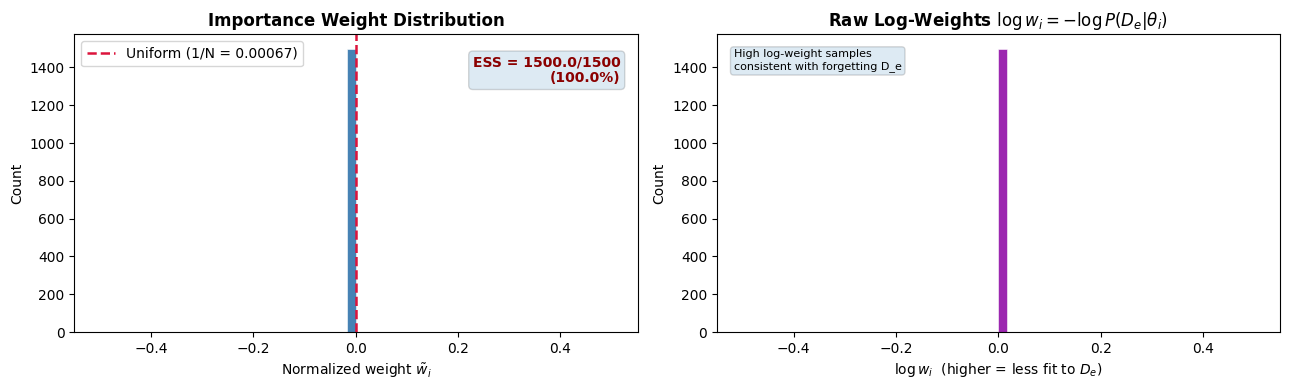

In [30]:
def perform_unlearning(D_e, posterior_samples):
    """
    MCU: compute normalized importance weights w̃_i = 1/P(D_e|θ_i).
    Returns a (num_samples,) array of normalized weights.
    """
    X_e, y_e = D_e
    w = posterior_samples['w']   # (N, d)
    b = posterior_samples['b']   # (N,)

    logits = jnp.dot(w, X_e.T) + b[:, None]        # (N, |D_e|)
    log_liks = dist.Bernoulli(logits=logits).log_prob(y_e)  # (N, |D_e|)
    total_log_lik = jnp.sum(log_liks, axis=1)       # (N,)

    log_weights = -total_log_lik                     # negate to get 1/P
    log_weights_norm = log_weights - jax.nn.logsumexp(log_weights)
    return jnp.exp(log_weights_norm)

print("Applying MCU Importance Sampling on phishing data...")
unlearning_weights = perform_unlearning(D_e, base_samples)
weights_np = np.array(unlearning_weights)

N = len(weights_np)
ess = 1.0 / np.sum(weights_np ** 2)
ess_pct = ess / N * 100
print(f"  N samples             : {N}")
print(f"  ESS                   : {ess:.1f}  ({ess_pct:.1f}% of N)")
print(f"  Max weight            : {weights_np.max():.6f}")
print(f"  Uniform weight (1/N)  : {1/N:.6f}")
if ess_pct < 10:
    print("  ⚠ WARNING: ESS < 10% — weight degeneracy detected!")
    print("    Consider using the Enlarged Candidate Set approach.")

# --- Importance weight histogram ---
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

axes[0].hist(weights_np, bins=60, color="steelblue", edgecolor="white", linewidth=0.4)
axes[0].axvline(1.0/N, color="crimson", linestyle="--", linewidth=1.8,
                label=f"Uniform (1/N = {1/N:.5f})")
axes[0].set_title("Importance Weight Distribution", fontweight="bold")
axes[0].set_xlabel("Normalized weight $\\tilde{w}_i$")
axes[0].set_ylabel("Count")
axes[0].legend()
axes[0].text(0.97, 0.93, f"ESS = {ess:.1f}/{N}\n({ess_pct:.1f}%)",
             transform=axes[0].transAxes, ha="right", va="top",
             color="darkred", fontweight="bold", fontsize=10,
             bbox=dict(boxstyle="round", alpha=0.15))
if ess_pct < 10:
    axes[0].set_facecolor("#fff0f0")
    axes[0].text(0.5, 0.5, "⚠ Weight Degeneracy",
                 transform=axes[0].transAxes, fontsize=11, ha="center",
                 color="red", alpha=0.35, fontweight="bold", rotation=12)

# Log-weight distribution
log_w_raw = np.array(-jnp.sum(
    dist.Bernoulli(logits=jnp.dot(base_samples['w'], X_e.T) +
                   base_samples['b'][:, None]).log_prob(y_e), axis=1))
axes[1].hist(log_w_raw, bins=60, color="#9C27B0", edgecolor="white", linewidth=0.4)
axes[1].set_title("Raw Log-Weights $\\log w_i = -\\log P(D_e|\\theta_i)$", fontweight="bold")
axes[1].set_xlabel("$\\log w_i$  (higher = less fit to $D_e$)")
axes[1].set_ylabel("Count")
axes[1].text(0.03, 0.95,
             "High log-weight samples\nconsistent with forgetting D_e",
             transform=axes[1].transAxes, fontsize=8, va="top",
             bbox=dict(boxstyle="round", alpha=0.15))

plt.tight_layout()
plt.show()

## Section 7 — Ground Truth Retrain on $D_r$ (Phishing)

Retrain the model from scratch on the retain set $D_r$ only; this is the gold-standard posterior that MCU should approximate.

Retraining from scratch on D_r (phishing retain set)...


sample: 100%|██████████| 2000/2000 [00:10<00:00, 190.66it/s, 15 steps of size 1.69e-01. acc. prob=0.93]



Bias b posterior summary:
  Base      mean: 1.0964  std: 0.1840
  Unlearned mean: 1.0964  (weighted from base)
  Retrained mean: 1.0947  std: 0.1805


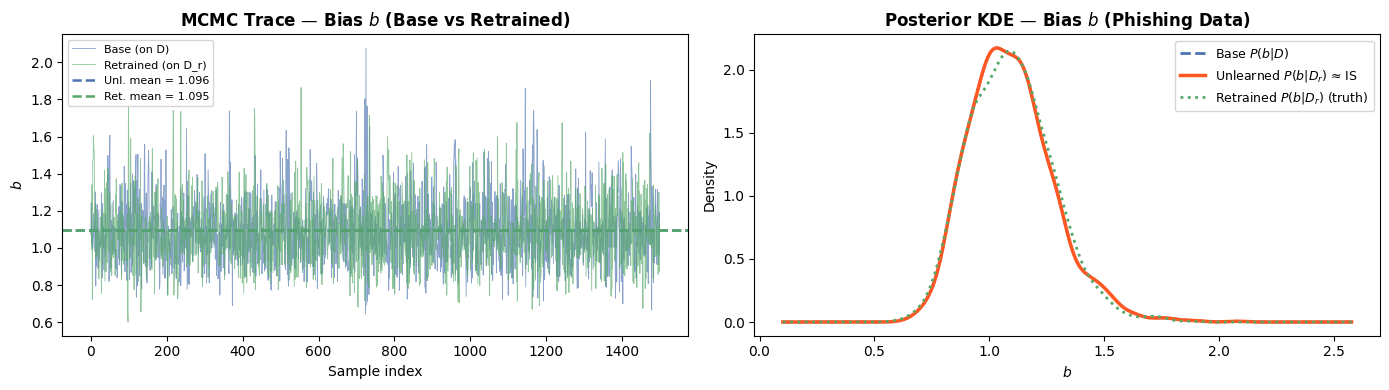

In [31]:
print("Retraining from scratch on D_r (phishing retain set)...")
retrained_samples = train_mcmc(X_r, y_r, num_warmup=500, num_samples=1500,
                                rng_key=random.PRNGKey(2))

b_base_np      = np.array(base_samples["b"])
b_retrained_np = np.array(retrained_samples["b"])
b_unlearned_mean = np.average(b_base_np, weights=weights_np)

print(f"\nBias b posterior summary:")
print(f"  Base      mean: {b_base_np.mean():.4f}  std: {b_base_np.std():.4f}")
print(f"  Unlearned mean: {b_unlearned_mean:.4f}  (weighted from base)")
print(f"  Retrained mean: {b_retrained_np.mean():.4f}  std: {b_retrained_np.std():.4f}")

# --- Overlay MCMC traces: Base vs Retrained ---
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(b_base_np,      alpha=0.65, color="#4C72B0", linewidth=0.6, label="Base (on D)")
axes[0].plot(b_retrained_np, alpha=0.65, color="#55A868", linewidth=0.6, label="Retrained (on D_r)")
axes[0].axhline(b_unlearned_mean,        color="#4C72B0", linestyle="--",
                linewidth=1.8, label=f"Unl. mean = {b_unlearned_mean:.3f}")
axes[0].axhline(b_retrained_np.mean(),   color="#55A868", linestyle="--",
                linewidth=1.8, label=f"Ret. mean = {b_retrained_np.mean():.3f}")
axes[0].set_title("MCMC Trace — Bias $b$ (Base vs Retrained)", fontweight="bold")
axes[0].set_xlabel("Sample index")
axes[0].set_ylabel("$b$")
axes[0].legend(fontsize=8)

# KDE overlay for b
z_range = np.linspace(
    min(b_base_np.min(), b_retrained_np.min()) - 0.5,
    max(b_base_np.max(), b_retrained_np.max()) + 0.5, 300)
kde_base_b = scipy.stats.gaussian_kde(b_base_np)
kde_ret_b  = scipy.stats.gaussian_kde(b_retrained_np)
kde_unl_b  = scipy.stats.gaussian_kde(b_base_np, weights=weights_np)

axes[1].plot(z_range, kde_base_b(z_range), "--", color="#4C72B0", linewidth=2,
             label="Base $P(b|D)$")
axes[1].plot(z_range, kde_unl_b(z_range),  "-",  color="#FF5722", linewidth=2.5,
             label="Unlearned $P(b|D_r)$ ≈ IS")
axes[1].plot(z_range, kde_ret_b(z_range),  ":",  color="#55A868", linewidth=2,
             label="Retrained $P(b|D_r)$ (truth)")
axes[1].set_title("Posterior KDE — Bias $b$ (Phishing Data)",
                  fontweight="bold")
axes[1].set_xlabel("$b$")
axes[1].set_ylabel("Density")
axes[1].legend(fontsize=9)

plt.tight_layout()
plt.show()

## Section 8 — Predictive Accuracy on Phishing Test Set

Evaluate Base, Unlearned, and Retrained models on the held-out phishing test set.

┌──────────────────────────────────┬──────────┐
│ Model                            │ Accuracy │
├──────────────────────────────────┼──────────┤
│ Base (trained on D)              │  0.9167  │
│ Unlearned (MCU IS-weighted)      │  0.9167  │
│ Retrained (ground truth)         │  0.9167  │
└──────────────────────────────────┴──────────┘


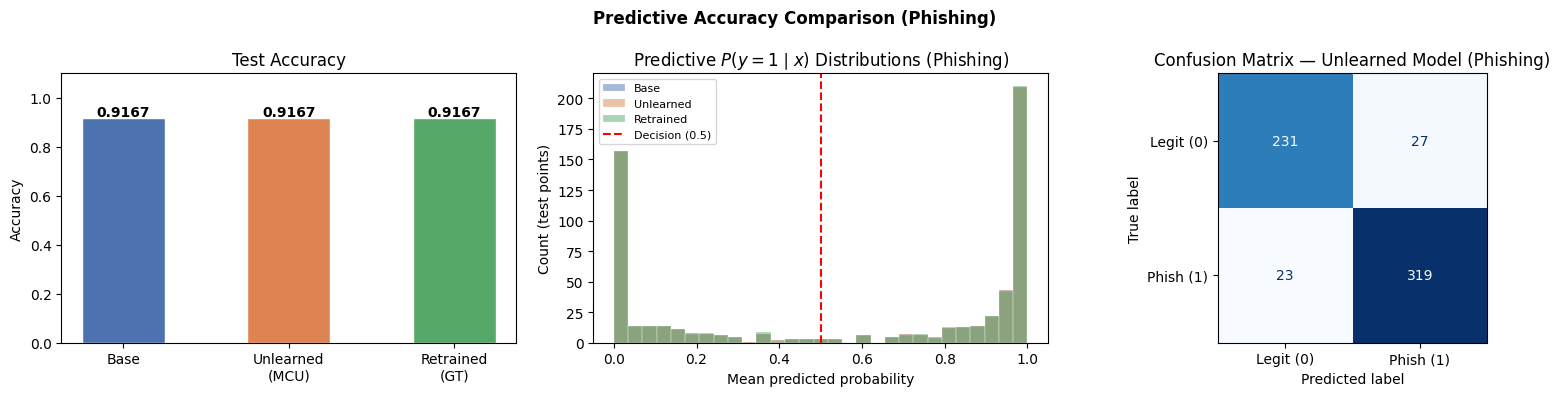

In [32]:
def predict(X, posterior_samples, weights=None):
    w = posterior_samples['w']
    b = posterior_samples['b']
    logits = jnp.dot(w, jnp.array(X, dtype=jnp.float32).T) + b[:, None]
    probs = jax.nn.sigmoid(logits)
    if weights is None:
        mean_probs = jnp.mean(probs, axis=0)
    else:
        mean_probs = jnp.sum(probs * weights[:, None], axis=0)
    return np.array((mean_probs > 0.5).astype(int)), np.array(mean_probs)

X_test, y_test = D_test
y_pred_base,      p_base = predict(X_test, base_samples)
y_pred_unlearned, p_unl  = predict(X_test, base_samples, weights=unlearning_weights)
y_pred_retrained, p_ret  = predict(X_test, retrained_samples)

acc_base      = accuracy_score(y_test, y_pred_base)
acc_unlearned = accuracy_score(y_test, y_pred_unlearned)
acc_retrained = accuracy_score(y_test, y_pred_retrained)

print("┌──────────────────────────────────┬──────────┐")
print("│ Model                            │ Accuracy │")
print("├──────────────────────────────────┼──────────┤")
print(f"│ Base (trained on D)              │  {acc_base:.4f}  │")
print(f"│ Unlearned (MCU IS-weighted)      │  {acc_unlearned:.4f}  │")
print(f"│ Retrained (ground truth)         │  {acc_retrained:.4f}  │")
print("└──────────────────────────────────┴──────────┘")

# --- Plots ---
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle("Predictive Accuracy Comparison (Phishing)", fontweight="bold")

# Accuracy bar
models = ["Base", "Unlearned\n(MCU)", "Retrained\n(GT)"]
accs   = [acc_base, acc_unlearned, acc_retrained]
colors = ["#4C72B0", "#DD8452", "#55A868"]
bars = axes[0].bar(models, accs, color=colors, edgecolor="white", width=0.5)
axes[0].set_ylim(0, 1.1)
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Test Accuracy")
for bar, acc in zip(bars, accs):
    axes[0].text(bar.get_x() + bar.get_width()/2, acc + 0.01,
                 f"{acc:.4f}", ha="center", fontsize=10, fontweight="bold")

# P(y=1|x) histogram
bins = np.linspace(0, 1, 30)
for ax, probs, name, col in [
    (axes[1], p_base, "Base",      "#4C72B0"),
    (axes[1], p_unl,  "Unlearned", "#DD8452"),
    (axes[1], p_ret,  "Retrained", "#55A868")
]:
    ax.hist(probs, bins=bins, alpha=0.5, color=col, label=name, edgecolor="white", linewidth=0.3)
axes[1].axvline(0.5, color="red", linestyle="--", linewidth=1.5, label="Decision (0.5)")
axes[1].set_title("Predictive $P(y=1\\mid x)$ Distributions (Phishing)")
axes[1].set_xlabel("Mean predicted probability")
axes[1].set_ylabel("Count (test points)")
axes[1].legend(fontsize=8)

# Confusion matrix for unlearned model
cm = confusion_matrix(y_test, y_pred_unlearned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legit (0)", "Phish (1)"])
disp.plot(ax=axes[2], colorbar=False, cmap="Blues")
axes[2].set_title("Confusion Matrix — Unlearned Model (Phishing)")

plt.tight_layout()
plt.show()

## Section 9 — Wasserstein Distance Between Unlearned and Retrained Posteriors

Compute 1-Wasserstein distances for each parameter dimension to quantify how close MCU unlearning on phishing data is to full retraining.

Average Wasserstein Distance (Unlearned vs Retrained, phishing): 0.0070
Unlearning quality: Excellent  ✓


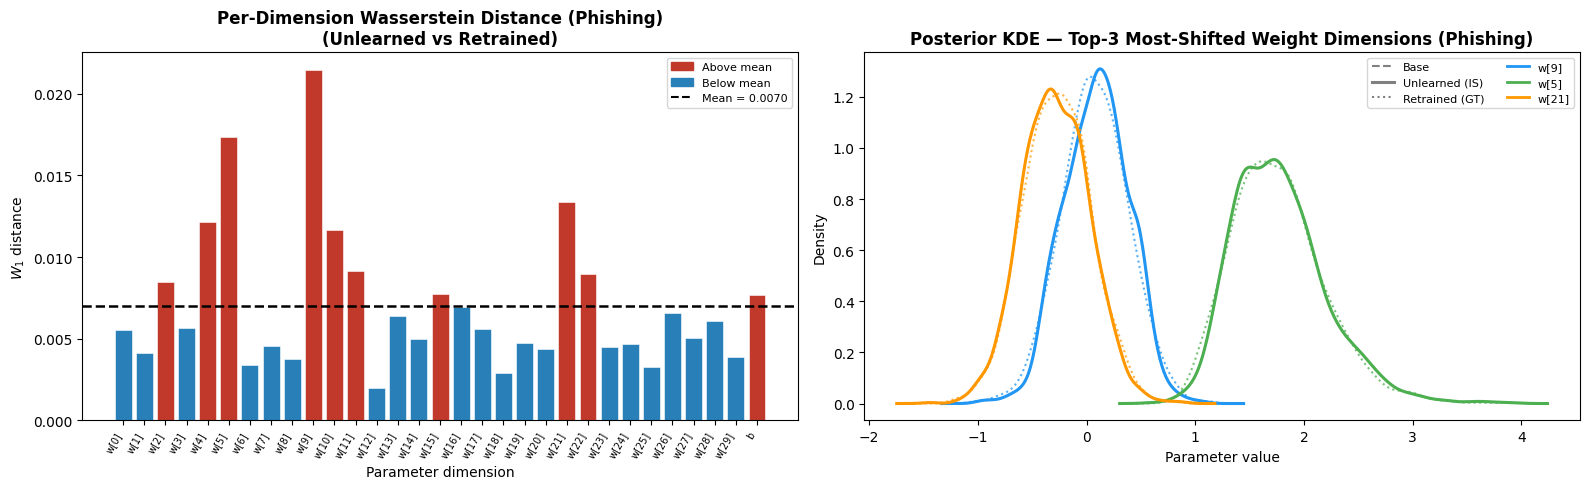

In [34]:
distances = []

for param_name in ['w', 'b']:
    s_unl = np.array(base_samples[param_name])
    s_ret = np.array(retrained_samples[param_name])
    if s_unl.ndim == 1:
        s_unl = s_unl.reshape(-1, 1)
        s_ret = s_ret.reshape(-1, 1)
    for d in range(s_unl.shape[1]):
        wd = scipy.stats.wasserstein_distance(
            u_values=s_unl[:, d],
            v_values=s_ret[:, d],
            u_weights=weights_np
)
        distances.append(wd)

avg_wd = np.mean(distances)

print(f"Average Wasserstein Distance (Unlearned vs Retrained, phishing): {avg_wd:.4f}")
if avg_wd < 0.05:
    quality = "Excellent  ✓"
elif avg_wd < 0.2:
    quality = "Good"
elif avg_wd < 0.5:
    quality = "Moderate — consider Enlarged Candidate Set"
else:
    quality = "Poor ✗ — weight degeneracy likely"
print(f"Unlearning quality: {quality}")

# --- Per-dimension bar chart ---
n_w = np.array(base_samples["w"]).shape[1]
dim_labels = [f"w[{i}]" for i in range(n_w)] + ["b"]
bar_colors = ["#c0392b" if d > avg_wd else "#2980b9" for d in distances]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

bars = axes[0].bar(dim_labels, distances, color=bar_colors, edgecolor="white", linewidth=0.4)
axes[0].axhline(avg_wd, color="black", linestyle="--", linewidth=1.8,
                label=f"Mean $W_1$ = {avg_wd:.4f}")
axes[0].set_title("Per-Dimension Wasserstein Distance (Phishing)\n(Unlearned vs Retrained)",
                  fontweight="bold")
axes[0].set_xlabel("Parameter dimension")
axes[0].set_ylabel("$W_1$ distance")
axes[0].set_xticklabels(dim_labels, rotation=60, ha="right", fontsize=7)
axes[0].legend(handles=[
    Patch(color="#c0392b", label="Above mean"),
    Patch(color="#2980b9", label="Below mean"),
    Line2D([0],[0], color="black", linestyle="--", label=f"Mean = {avg_wd:.4f}")
], fontsize=8)

# Posterior KDE for top-3 most-shifted dimensions
top3_shifted = np.argsort(distances[:-1])[-3:][::-1]
palette_kde  = ["#2196F3", "#4CAF50", "#FF9800"]
w_base_np    = np.array(base_samples["w"])
w_ret_np     = np.array(retrained_samples["w"])

for rank, dim in enumerate(top3_shifted):
    col      = palette_kde[rank]
    x_b      = w_base_np[:, dim]
    x_r      = w_ret_np[:, dim]
    x_range  = np.linspace(min(x_b.min(), x_r.min()) - 0.3,
                            max(x_b.max(), x_r.max()) + 0.3, 300)
    kde_b = scipy.stats.gaussian_kde(x_b)
    kde_u = scipy.stats.gaussian_kde(x_b, weights=weights_np)
    kde_r = scipy.stats.gaussian_kde(x_r)
    lbl = f"w[{dim}]"
    axes[1].plot(x_range, kde_b(x_range), "--",  color=col, alpha=0.55, linewidth=1.5,
                 label=f"Base {lbl}")
    axes[1].plot(x_range, kde_u(x_range), "-",   color=col, alpha=1.0,  linewidth=2.2,
                 label=f"Unlearned {lbl}")
    axes[1].plot(x_range, kde_r(x_range), ":",   color=col, alpha=0.75, linewidth=1.5,
                 label=f"Retrained {lbl}")

axes[1].set_title("Posterior KDE — Top-3 Most-Shifted Weight Dimensions (Phishing)",
                  fontweight="bold")
axes[1].set_xlabel("Parameter value")
axes[1].set_ylabel("Density")
custom_handles = [
    Line2D([0],[0], linestyle="--", color="grey", lw=1.5, label="Base"),
    Line2D([0],[0], linestyle="-",  color="grey", lw=2.2, label="Unlearned (IS)"),
    Line2D([0],[0], linestyle=":",  color="grey", lw=1.5, label="Retrained (GT)"),
] + [Line2D([0],[0], color=palette_kde[i], lw=2, label=f"w[{top3_shifted[i]}]")
     for i in range(3)]
axes[1].legend(handles=custom_handles, fontsize=8, ncol=2)

plt.tight_layout()
plt.show()

## Section 10 — (Optional) Full Diagnostic Dashboard for Phishing Data

If you want the same 2×3 diagnostic dashboard as in the MCU notebook, you can copy the `plot_all_diagnostics` function from that notebook and adapt only the file name (e.g. `mcu_diagnostics_phishing_{mode}.png`).

The core MCU experiment for the **real phishing dataset** is now complete:
- Base vs Unlearned vs Retrained posterior on phishing data
- Test accuracies on phishing test set
- Wasserstein distance between unlearned and retrained posteriors.

In [38]:
def plot_all_diagnostics(base_samples, retrained_samples, unlearning_weights, D_test, mode_label="random"):

    """Create a 2x3 diagnostic dashboard summarizing MCU vs retraining.



    Panels (left-to-right, top-to-bottom):

      (0,0) Accuracy bar plot (Base / Unlearned / Retrained)

      (0,1) Predictive P(y=1|x) histograms on test set

      (0,2) Confusion matrix of Unlearned model

      (1,0) Importance-weight histogram + ESS annotation

      (1,1) Posterior KDE of bias b (Base / Unlearned / Retrained)

      (1,2) Per-parameter Wasserstein distances between Unlearned and Retrained

    """



    X_test, y_test = D_test



    # --- 1. Predictive accuracies on test set ---

    y_pred_base,      p_base = predict(X_test, base_samples)

    y_pred_unlearned, p_unl  = predict(X_test, base_samples, weights=unlearning_weights)

    y_pred_retrained, p_ret  = predict(X_test, retrained_samples)



    acc_base      = accuracy_score(y_test, y_pred_base)

    acc_unlearned = accuracy_score(y_test, y_pred_unlearned)

    acc_retrained = accuracy_score(y_test, y_pred_retrained)



    # --- 2. Importance weights + ESS ---

    weights_np = np.asarray(unlearning_weights, dtype=float)

    N = len(weights_np)

    ess = 1.0 / np.sum(weights_np ** 2)

    ess_pct = ess / N * 100.0



    # --- 3. Posterior samples (bias b) ---

    b_base_np      = np.asarray(base_samples["b"], dtype=float)

    b_retrained_np = np.asarray(retrained_samples["b"], dtype=float)

    b_unl_mean     = np.average(b_base_np, weights=weights_np)



    # --- 4. Wasserstein distances per parameter ---

    distances = []

    for param_name in ["w", "b"]:

        s_unl = np.asarray(base_samples[param_name], dtype=float)

        s_ret = np.asarray(retrained_samples[param_name], dtype=float)

        if s_unl.ndim == 1:

            s_unl = s_unl.reshape(-1, 1)

            s_ret = s_ret.reshape(-1, 1)

        for d in range(s_unl.shape[1]):

            wd = scipy.stats.wasserstein_distance(

                u_values=s_unl[:, d],

                v_values=s_ret[:, d],

                u_weights=weights_np,

            )

            distances.append(wd)



    avg_wd = float(np.mean(distances)) if len(distances) > 0 else 0.0



    # Labels for per-dimension bars (all w's then b)

    n_w = np.asarray(base_samples["w"]).shape[1]

    dim_labels = [f"w[{i}]" for i in range(n_w)] + ["b"]

    bar_colors = ["#c0392b" if d > avg_wd else "#2980b9" for d in distances]



    # --- 5. Create 2x3 dashboard ---

    fig, axes = plt.subplots(2, 3, figsize=(18, 8))

    fig.suptitle(f"MCU Diagnostics on Phishing Data (mode = {mode_label})", fontweight="bold")



    # (0,0) Accuracy bar plot

    ax = axes[0, 0]

    models = ["Base", "Unlearned\n(MCU)", "Retrained\n(GT)"]

    accs   = [acc_base, acc_unlearned, acc_retrained]

    colors = ["#4C72B0", "#DD8452", "#55A868"]

    bars = ax.bar(models, accs, color=colors, edgecolor="white", width=0.5)

    ax.set_ylim(0, 1.05)

    ax.set_ylabel("Accuracy")

    ax.set_title("Test Accuracy")

    for bar, acc in zip(bars, accs):

        ax.text(bar.get_x() + bar.get_width() / 2.0, acc + 0.01,

                f"{acc:.3f}", ha="center", va="bottom", fontsize=9, fontweight="bold")



    # (0,1) Predictive probability histograms

    ax = axes[0, 1]

    bins = np.linspace(0, 1, 30)

    for probs, name, col in [

        (p_base, "Base",      "#4C72B0"),

        (p_unl,  "Unlearned", "#DD8452"),

        (p_ret,  "Retrained", "#55A868"),

    ]:

        ax.hist(probs, bins=bins, alpha=0.45, color=col,

                label=name, edgecolor="white", linewidth=0.3)

    ax.axvline(0.5, color="red", linestyle="--", linewidth=1.4, label="Decision 0.5")

    ax.set_title("Predictive $P(y=1\\mid x)$ on Test Set")

    ax.set_xlabel("Mean predicted probability")

    ax.set_ylabel("Count")

    ax.legend(fontsize=8)



    # (0,2) Confusion matrix for unlearned model

    ax = axes[0, 2]

    cm = confusion_matrix(y_test, y_pred_unlearned)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legit (0)", "Phish (1)"])

    disp.plot(ax=ax, colorbar=False, cmap="Blues")

    ax.set_title("Confusion Matrix — Unlearned (MCU)")



    # (1,0) Importance weight histogram + ESS

    ax = axes[1, 0]

    ax.hist(weights_np, bins=60, color="steelblue", edgecolor="white", linewidth=0.4)

    ax.axvline(1.0 / N, color="crimson", linestyle="--", linewidth=1.6,

               label=f"Uniform 1/N = {1.0 / N:.4f}")

    ax.set_title("Importance Weight Distribution")

    ax.set_xlabel("Normalized weight $\\~w_i$")

    ax.set_ylabel("Count")

    ax.legend(fontsize=8)

    ax.text(0.97, 0.93,

            f"ESS = {ess:.1f}/{N} ({ess_pct:.1f}%)",

            transform=ax.transAxes, ha="right", va="top",

            fontsize=9, color="darkred", fontweight="bold",

            bbox=dict(boxstyle="round", alpha=0.15))

    if ess_pct < 10:

        ax.set_facecolor("#fff0f0")

        ax.text(0.5, 0.5, "Weight\nDegeneracy",

                transform=ax.transAxes, ha="center", va="center",

                fontsize=10, color="red", alpha=0.35, fontweight="bold")



    # (1,1) Posterior KDE for bias b

    ax = axes[1, 1]

    z_range = np.linspace(

        min(b_base_np.min(), b_retrained_np.min()) - 0.5,

        max(b_base_np.max(), b_retrained_np.max()) + 0.5,

        300,

    )

    kde_base_b = scipy.stats.gaussian_kde(b_base_np)

    kde_ret_b  = scipy.stats.gaussian_kde(b_retrained_np)

    kde_unl_b  = scipy.stats.gaussian_kde(b_base_np, weights=weights_np)

    ax.plot(z_range, kde_base_b(z_range), "--", color="#4C72B0", linewidth=2, label="Base $P(b|D)$")

    ax.plot(z_range, kde_unl_b(z_range),  "-",  color="#FF5722", linewidth=2.5, label="Unlearned $P(b|D_r)$")

    ax.plot(z_range, kde_ret_b(z_range),  ":",  color="#55A868", linewidth=2, label="Retrained $P(b|D_r)$")

    ax.axvline(b_unl_mean, color="#FF5722", linestyle="-", linewidth=1.2)

    ax.axvline(b_retrained_np.mean(), color="#55A868", linestyle=":", linewidth=1.2)

    ax.set_title("Posterior KDE — Bias $b$")

    ax.set_xlabel("$b$")

    ax.set_ylabel("Density")

    ax.legend(fontsize=8)



    # (1,2) Wasserstein distances per parameter

    ax = axes[1, 2]

    bars = ax.bar(dim_labels, distances, color=bar_colors, edgecolor="white", linewidth=0.4)

    ax.axhline(avg_wd, color="black", linestyle="--", linewidth=1.6,

               label=f"Mean $W_1$ = {avg_wd:.4f}")

    ax.set_title("Per-Parameter Wasserstein Distance\n(Unlearned vs Retrained)")

    ax.set_xlabel("Parameter")

    ax.set_ylabel("$W_1$ distance")

    ax.set_xticklabels(dim_labels, rotation=60, ha="right", fontsize=7)

    ax.legend(fontsize=7)



    plt.tight_layout(rect=[0, 0, 1, 0.96])

    plt.show()


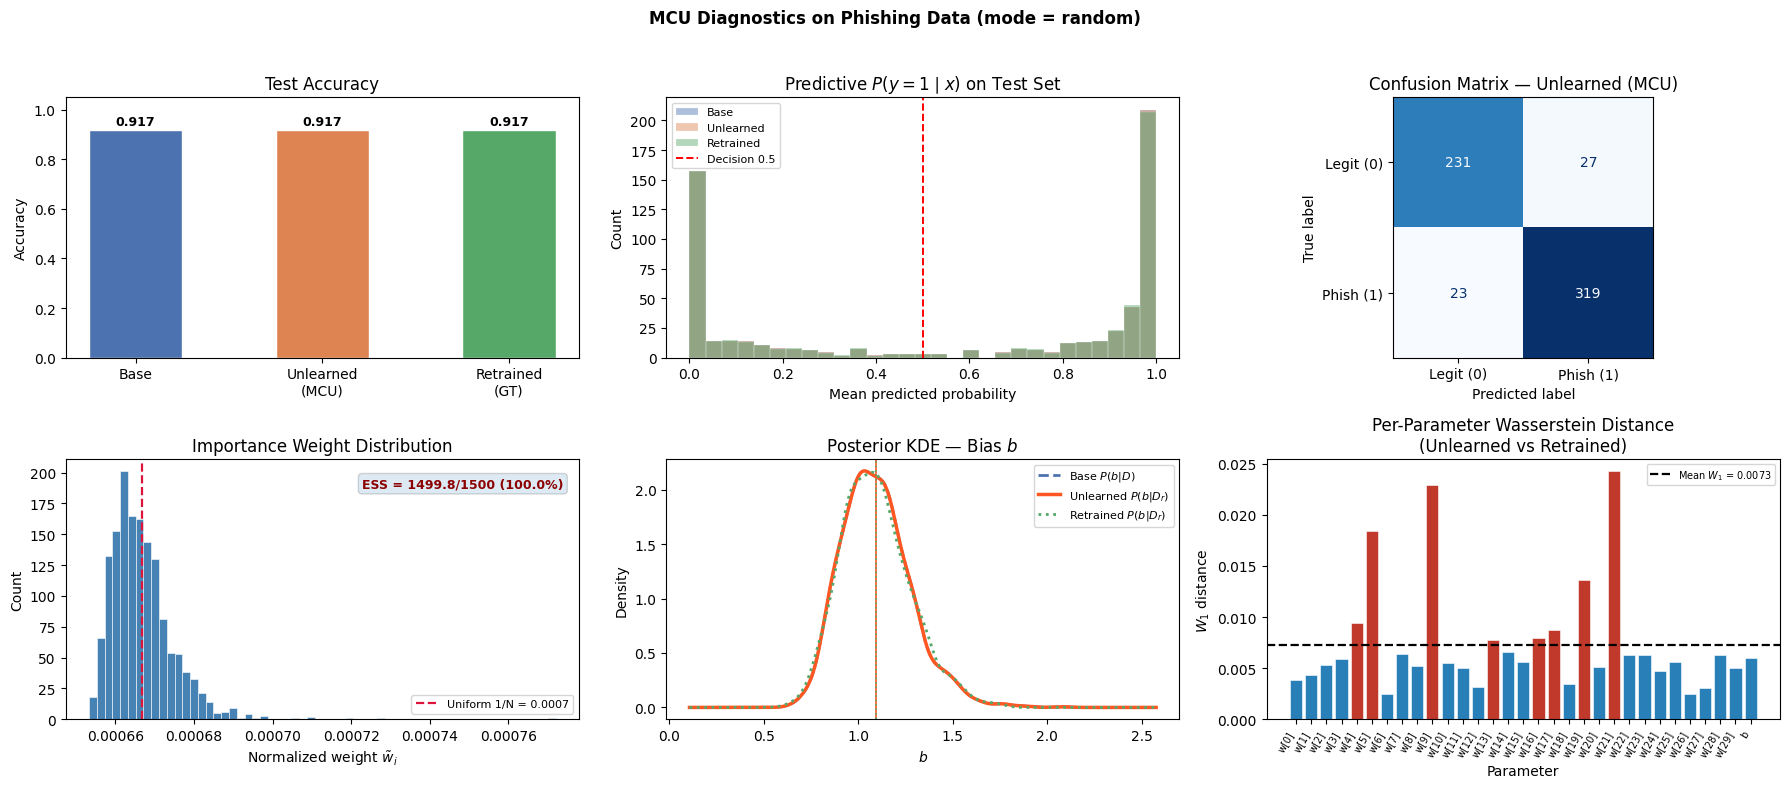

In [24]:
# Run after base_samples, retrained_samples, unlearning_weights, D_test, and active_mode exist
plot_all_diagnostics(
    base_samples=base_samples,
    retrained_samples=retrained_samples,
    unlearning_weights=unlearning_weights,
    D_test=D_test,
    mode_label=active_mode,   # e.g. "random" or "cluster"
)